In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in Python modules
import datetime
import inspect
import os
import csv

# Python add-ons
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates as mpl_dates
from scipy import stats

# For accessing UNIDATA THREDDS servers
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

# Sandia PVLIB-Python Module
import pvlib
from pvlib import solarposition, irradiance, atmosphere, pvsystem

# Sandia PVLIB-Python Forecasting Class
from pvlib.forecast import GFS, HRRR_ESRL, NAM, NDFD, HRRR, RAP

# Sandia PVLIB-Python Location Class
from pvlib.location import Location

# Sandia PVLIB-Python PV Power Classes
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/forecast.py:21: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The API may change, the functionality may be consolidated into an io ' +


In [2]:
latitude = 4.6024
longitude = -74.0674
tz = 'America/Bogota' #Time Zone at Bogotá, Colombia

#start = pd.Timestamp(pd.datetime.now(), tz=tz) # Today's date
#end = start + pd.Timedelta(days=-7) # 7 days back from today

start = pd.Timestamp('2020-05-05', tz=tz) # Start of Init-May (May 05, 2020)
end = pd.Timestamp('2020-05-11', tz=tz) # End of Init-May (May 11, 2020)

location = Location(latitude,longitude,tz,altitude=2624)

In [3]:
file_name = '/Users/nelsonsasa07/Documents/PV Simulations/Meteocontrol/Meteocontrol_Data_Minute.xlsx'

#Meteocontrol Irradiance Measurement
irrad_sheet = 'Radiacin_2020_05_11'
measured_irrad = pd.read_excel(io=file_name, sheet_name=irrad_sheet)
measured_irrad = pd.DataFrame(measured_irrad)

#Meteocontrol DC Voltage Measurement
dcvoltage_sheet = 'Tensin_DC_2020_05_11'
measured_dcvoltage = pd.read_excel(io=file_name, sheet_name=dcvoltage_sheet)
measured_dcvoltage = pd.DataFrame(measured_dcvoltage)

#Meteocontrol DC Current Measurement
dccurrent_sheet = 'Corriente_DC_2020_05_11'
measured_dccurrent = pd.read_excel(io=file_name, sheet_name=dccurrent_sheet)
measured_dccurrent = pd.DataFrame(measured_dccurrent)

#Meteocontrol DC Power Measurement
dcpower_sheet = 'Potencia_DC_2020_05_11'
measured_dcpower = pd.read_excel(io=file_name, sheet_name=dcpower_sheet)
measured_dcpower = pd.DataFrame(measured_dcpower)

#Meteocontrol AC Power Measurement
acpower_sheet = 'Potencia_AC_2020_05_11'
measured_acpower = pd.read_excel(io=file_name, sheet_name=acpower_sheet)
measured_acpower = pd.DataFrame(measured_acpower)

#Meteocontrol Module Temperature Measurement
modtemp_sheet = 'Temperatura-Energa_2020_05_11'
measured_modtemp = pd.read_excel(io=file_name, sheet_name=modtemp_sheet)
measured_modtemp = pd.DataFrame(measured_modtemp)

#Meteocontrol Energy Measurement
energy_sheet = 'Energa_2020_05_11'
measured_energy = pd.read_excel(io=file_name, sheet_name=energy_sheet)
measured_energy = pd.DataFrame(measured_energy)

In [4]:
new_irrad = []
for data in measured_irrad['Meteocontrol Irrad., W/m2']:
    if data <= 1.5:
        new_irrad.append(0)
    else:
        new_irrad.append(data)

new_irrad = pd.DataFrame(new_irrad)

new_irrad = new_irrad.set_index(measured_irrad.index)

measured_irrad['New Meteo. Irrad., W/m2'] = new_irrad
measured_irrad

,Month,Day,Hour,"Lufft Irrad., W/m2","Meteocontrol Irrad., W/m2","New Meteo. Irrad., W/m2"
0,5,5,00:00:00,0.00,1.00,0.0
1,5,5,00:05:00,0.00,1.00,0.0
2,5,5,00:10:00,0.00,1.00,0.0
3,5,5,00:15:00,0.00,1.00,0.0
4,5,5,00:20:00,0.00,1.00,0.0
...,...,...,...,...,...,...
2011,5,11,23:35:00,0.00,1.01,0.0
2012,5,11,23:40:00,0.00,1.01,0.0
2013,5,11,23:45:00,0.00,1.01,0.0
2014,5,11,23:50:00,0.00,1.00,0.0


In [5]:
# Get the Inversors Characteristics from the Database Selected
# There is two modules due to the fact that the University Solar Park is compound by two different systems
# The user can check the databases here: https://github.com/BreakingBytes/simkit/tree/master/examples/PVPower/pvpower

inverters_database = 'CECInverter';

inverters = retrieve_sam(inverters_database);
inverter_A = inverters.ABB__TRIO_50_0_TL_OUTD_US_480__480V__480V__CEC_2018_; #51.24 kWp System
inverter_B = inverters.ABB__TRIO_27_6_TL_OUTD_S_US_480__480V__480V__CEC_2018_; #28.82 kWp System

In [6]:
# Name,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,I_mp_ref,V_mp_ref,alpha_sc,beta_oc,T_NOCT,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
# LG Electronics Inc. LG400N2W-A5,Mono-c-Si,0,400.316000,368.400000,2,2,1,72,10.470000,49.300000,9.860000,40.600000,0.003141,-0.128180,47.700000,1.821208,10.481150,1.807477e-11,0.312859,293.805420,9.380614,-0.360000,N,SAM 2018.11.11 r2,1/3/2019

LG400N2WA5 = {
'BIPV':                'N',
'Date':          '1/3/2019',
'T_NOCT':             47.7,
'A_c':                 2.0,
'N_s':                  72,
'I_sc_ref':          10.47,
'V_oc_ref':           49.3,
'I_mp_ref':           9.86,
'V_mp_ref':           40.6,
'alpha_sc':       0.003141,
'beta_oc':        -0.12180,
'a_ref':            1.821208,
'I_L_ref':          10.481150,
'I_o_ref':         1.807477e-11,
'R_s':               0.312859,
'R_sh_ref':         293.805420,
'Adjust':            9.380614,
'gamma_r':          -0.36,
'Version':          'NRELv1',
'PTC':               368.4,
'Technology':    'Mono-c-Si',
'Name': 'LG Electronics LG385N2W-A5',
    
#PVSyst Required Variables
'gamma_ref':         1.013, #Diode Quality Factor, Value from PVSyst    
'mu_gamma':          0, #PVSyst specify that mono-cSi modules mu_gamma is very close to zero
'R_sh_0':            3500, #Resistance shunt at 0 irrad., Value from PVSyst                                                           
'R_sh_exp':          5.5, #Experimental resistance shunt, Value from PVSyst
'cells_in_series':  72,    
'EgRef':            1.121,

#PVWatts Required Variables   
'pdc0':              400.316, #Value from PVWatts API and validated with PVSyst API
'gamma_pdc':        -0.0036 #Value from PVWatts API and validated with PVSyst API
}

module = pd.Series(LG400N2WA5, name='LG_Electronics_LG385N2W_A5')

In [7]:
# Definition of the Los Andes Photovoltaic Systems

LosAndesSys = 'Los Andes 80 kWp System';

#System A
sysA_name = 'Los Andes 51.25 kWp System Capacity';
mps_SysA = 16; #Modules Per String
spi_SysA = 8; #Strings Per Inverter

system_A = PVSystem(module_parameters=module, inverter_parameters=inverter_A, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysA, strings_per_inverter=spi_SysA)

#System B
sysB_name = 'Los Andes 28.82 kWp System Capacity';
mps_SysB = 18; #Modules Per String
spi_SysB = 4; #Strings Per Inverter
system_B = PVSystem(module_parameters=module, inverter_parameters=inverter_B, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysB, strings_per_inverter=spi_SysB)

In [8]:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_cec(measured_irrad['New Meteo. Irrad., W/m2'],
                                                     measured_modtemp['Modules Temp., °C'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=9.380614,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info = pvsystem.singlediode(photocurrent=IL,
                                  saturation_current=I0,
                                  resistance_series=Rs,
                                  resistance_shunt=Rsh,
                                  nNsVth=nNsVth,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating CEC et. al. Single Diode Results
data_i_sc = pd.Series(curve_info['i_sc'])
data_v_oc = pd.Series(curve_info['v_oc'])
data_i_mp = pd.Series(curve_info['i_mp'])
data_v_mp = pd.Series(curve_info['v_mp'])
data_p_mp = pd.Series(curve_info['p_mp'])
data_i_x = pd.Series(curve_info['i_x'])
data_i_xx = pd.Series(curve_info['i_xx'])

results_general = pd.DataFrame({'i_sc': data_i_sc, 
                        'v_oc': data_v_oc,
                        'i_mp': data_i_mp, 
                        'v_mp': data_v_mp, 
                        'p_mp': data_p_mp, 
                        'i_x': data_i_x,
                        'i_xx': data_i_xx})

year = start.year
month = start.month
str_date = []

for day, hour in list(zip(measured_irrad['Day'], measured_irrad['Hour'])):
    if day < 10 and month < 10:
        str_date.append('{}-0{}-0{} {}'.format(year, month, day, hour))
    else:
        str_date.append('{}-{}-{} {}'.format(year, month, day, hour))

datetime_index = str_date

sc_SysA = system_A.scale_voltage_current_power(results_general)
sc_SysA['Datetime'] = pd.to_datetime(datetime_index)
sc_SysA = sc_SysA.set_index('Datetime')

sc_SysB = system_B.scale_voltage_current_power(results_general)
sc_SysB['Datetime'] = pd.to_datetime(datetime_index)
sc_SysB = sc_SysB.set_index('Datetime')

# DC VOLTAGE

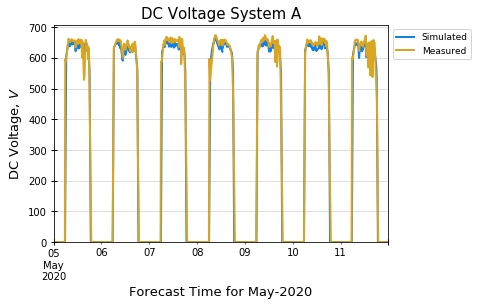

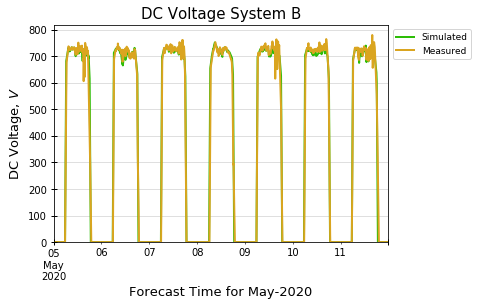

In [9]:
measured_dcvoltage = measured_dcvoltage.set_index(sc_SysA.index)

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

sc_SysA['v_mp'].plot(label='Simulated', color='#1580E4', linewidth=2)
measured_dcvoltage['DC Voltage SysA String 1, V'].plot(label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Voltage System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=9);
plt.tight_layout;
plt.savefig('Line_DCVol_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

sc_SysB['v_mp'].plot(label='Simulated', color='#2DBD07', linewidth=2)
measured_dcvoltage['DC Voltage SysB String 1, V'].plot(label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Voltage System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=9);
plt.tight_layout;
plt.savefig('Line_DCVol_SysB.eps', bbox_inches='tight')

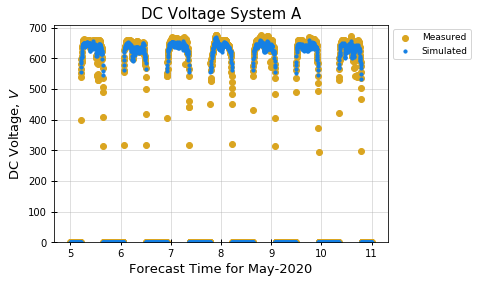

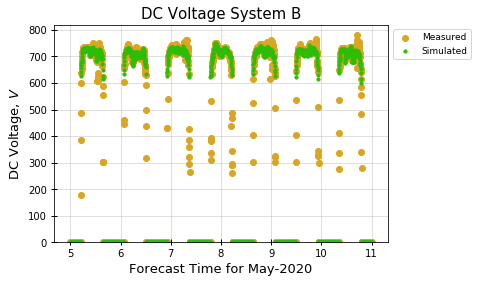

In [10]:
x_axis = np.linspace(int(start.day), int(end.day), int(len(sc_SysA['v_mp'])))

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.scatter(x_axis, measured_dcvoltage['DC Voltage SysA String 1, V'], label='Measured', color='goldenrod')
plt.scatter(x_axis, sc_SysA['v_mp'], label='Simulated', color='#1580E4', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Voltage System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Scatter_DCVol_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.scatter(x_axis, measured_dcvoltage['DC Voltage SysB String 1, V'], label='Measured', color='goldenrod')
plt.scatter(x_axis, sc_SysB['v_mp'], label='Simulated', color='#2DBD07', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Voltage System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Scatter_DCVol_SysB.eps', bbox_inches='tight')

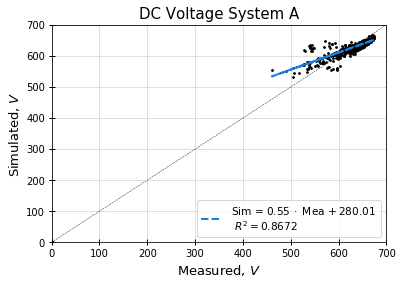

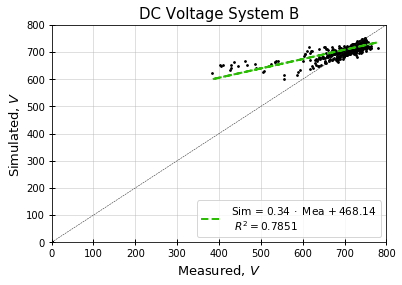

In [11]:
#System A
meas_voltage_SysA = []
sim_voltage_SysA = []

limvalue_SysA = 280

for i,j in list(zip(measured_dcvoltage['DC Voltage SysA String 1, V'], sc_SysA['v_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        meas_voltage_SysA.append(0)
    else:
        meas_voltage_SysA.append(i)

for i,j in list(zip(measured_dcvoltage['DC Voltage SysA String 1, V'], sc_SysA['v_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        sim_voltage_SysA.append(0)
    else:
        sim_voltage_SysA.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_voltage_SysA, sim_voltage_SysA)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();

x = np.linspace(0, 700, 700)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Sim = " + f"{slope_SysA.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(meas_voltage_SysA, sim_voltage_SysA, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Voltage System A', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $V$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, 700);
plt.ylim(0, 700);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_DC_Voltage_SysA.eps', bbox_inches='tight')

#System B
meas_voltage_SysB = []
sim_voltage_SysB = []

limvalue_SysB = 250

for i,j in list(zip(measured_dcvoltage['DC Voltage SysB String 1, V'], sc_SysB['v_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        meas_voltage_SysB.append(0)
    else:
        meas_voltage_SysB.append(i)

for i,j in list(zip(measured_dcvoltage['DC Voltage SysB String 1, V'], sc_SysB['v_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        sim_voltage_SysB.append(0)
    else:
        sim_voltage_SysB.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_voltage_SysB, sim_voltage_SysB)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();

x = np.linspace(0, 800, 800)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Sim = " + f"{slope_SysB.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(meas_voltage_SysB, sim_voltage_SysB, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Voltage System B', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $V$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, 800);
plt.ylim(0, 800);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_DC_Voltage_SysB.eps', bbox_inches='tight')

# DC CURRENT

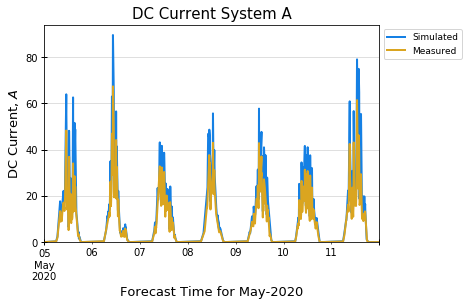

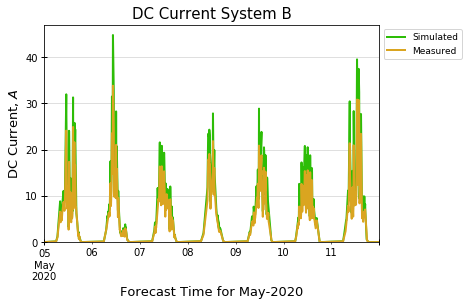

In [12]:
measured_dccurrent = measured_dccurrent.set_index(sc_SysA.index)

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

sc_SysA['i_mp'].plot(label='Simulated', color='#1580E4', linewidth=2)
measured_dccurrent['DC Current SysA String 1, A'].plot(label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=9);
plt.tight_layout;
plt.savefig('Line_DCCur_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

sc_SysB['i_mp'].plot(label='Simulated', color='#2DBD07', linewidth=2)
measured_dccurrent['DC Current SysB, A'].plot(label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Line_DCCur_SysB.eps', bbox_inches='tight')

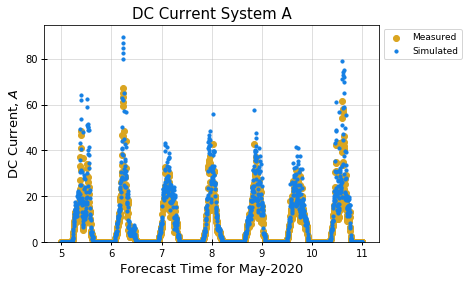

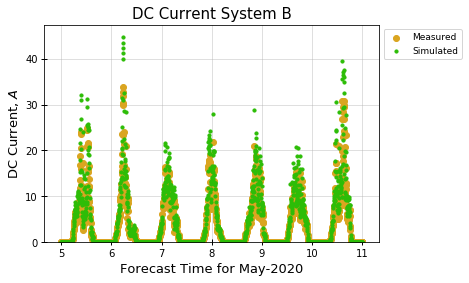

In [13]:
x_axis = np.linspace(int(start.day), int(end.day), int(len(sc_SysA['i_mp'])))

#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.scatter(x_axis, measured_dccurrent['DC Current SysA String 1, A'], label='Measured', color='goldenrod')
plt.scatter(x_axis, sc_SysA['i_mp'], label='Simulated', color='#1580E4', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Scatter_DCCur_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.scatter(x_axis, measured_dccurrent['DC Current SysB, A'], label='Measured', color='goldenrod')
plt.scatter(x_axis, sc_SysB['i_mp'], label='Simulated', color='#2DBD07', s=10)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Scatter_DCCur_SysB.eps', bbox_inches='tight')

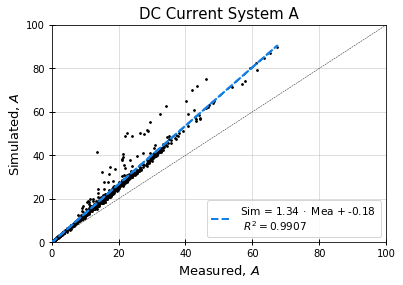

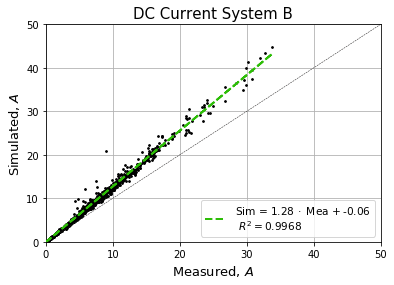

In [14]:
#System A
meas_current_SysA = []
sim_current_SysA = []

limvalue_SysA = 280

for i,j in list(zip(measured_dccurrent['DC Current SysA String 1, A'], sc_SysA['i_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        meas_current_SysA.append(0)
    else:
        meas_current_SysA.append(i)

for i,j in list(zip(measured_dccurrent['DC Current SysA String 1, A'], sc_SysA['i_mp'])):
    if i - j > limvalue_SysA or i - j < -limvalue_SysA:
        sim_current_SysA.append(0)
    else:
        sim_current_SysA.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_current_SysA, sim_current_SysA)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 100

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Sim = " + f"{slope_SysA.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(meas_current_SysA, sim_current_SysA, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current System A', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $A$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_DC_Current_SysA.eps', bbox_inches='tight')

#System B
meas_current_SysB = []
sim_current_SysB = []

limvalue_SysB = 100

for i,j in list(zip(measured_dccurrent['DC Current SysB, A'], sc_SysB['i_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        meas_current_SysB.append(0)
    else:
        meas_current_SysB.append(i)

for i,j in list(zip(measured_dccurrent['DC Current SysB, A'], sc_SysB['i_mp'])):
    if i - j > limvalue_SysB or i - j < -limvalue_SysB:
        sim_current_SysB.append(0)
    else:
        sim_current_SysB.append(j)

#Least Squares Linear Regression
x_value = []
y_value = []
for i,j in list(zip(meas_current_SysB, sim_current_SysB)):
    if i == 0 and j == 0:
        pass
    else:
        x_value.append(i)
        y_value.append(j)

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 50

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Sim = " + f"{slope_SysB.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(meas_current_SysB, sim_current_SysB, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current System B', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $A$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_DC_Current_SysB.eps', bbox_inches='tight')

# DC Power

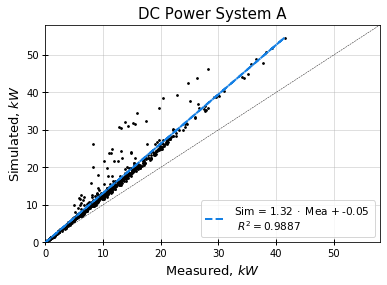

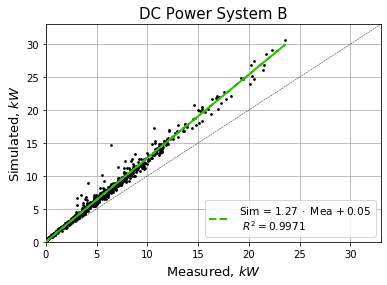

In [15]:
kilo = 1000;

#System A
#Least Squares Linear Regression
x_value = measured_dcpower['DC Power SysA String 1, W']/kilo
y_value = sc_SysA['p_mp']/kilo

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 58

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Sim = " + f"{slope_SysA.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_dcpower['DC Power SysA String 1, W']/kilo, sc_SysA['p_mp']/kilo, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Power System A', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_DC_Power_SysA.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_dcpower['DC Power SysB, W']/kilo
y_value = sc_SysB['p_mp']/kilo

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 33

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Sim = " + f"{slope_SysB.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_dcpower['DC Power SysB, W']/kilo, sc_SysB['p_mp']/kilo, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Power System B', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_DC_Power_SysB.eps', bbox_inches='tight')

# AC POWER

In [16]:
ACPow_SysA = pvsystem.snlinverter(sc_SysA['v_mp'], sc_SysA['p_mp'], inverter_A)/kilo;
ACPow_SysB = pvsystem.snlinverter(sc_SysB['v_mp'], sc_SysB['p_mp'], inverter_B)/kilo;

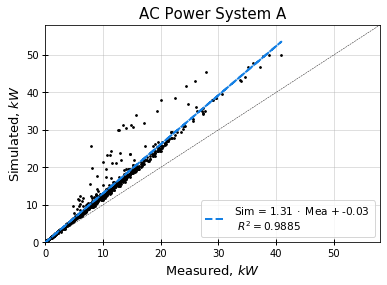

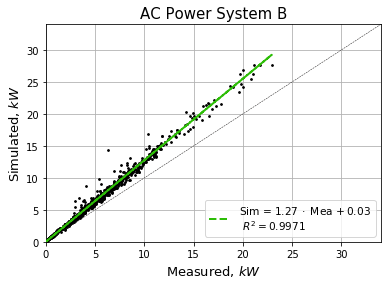

In [17]:
#System A
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysA, W']/kilo
y_value = ACPow_SysA

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 58

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Sim = " + f"{slope_SysA.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysA, W']/kilo, ACPow_SysA, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('AC Power System A', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_AC_Power_SysA.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_acpower['AC Power SysB, W']/kilo
y_value = ACPow_SysB

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 34

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Sim = " + f"{slope_SysB.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_acpower['AC Power SysB, W']/kilo, ACPow_SysB, color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('AC Power System B', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $kW$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_AC_Power_SysB.eps', bbox_inches='tight')

# DAILY ENERGY

In [18]:
#SystemA
ACPow_SysA = pd.DataFrame(ACPow_SysA)
ACPow_SysA['Day'] = ACPow_SysA.index.day
ACPow_SysA['AC Power'] = ACPow_SysA[0]
del ACPow_SysA[0]

fix_ACPow_SysA = []
for data in ACPow_SysA['AC Power']:
    if data < 0:
        fix_ACPow_SysA.append(0)
    else:
        fix_ACPow_SysA.append(data)

del ACPow_SysA['AC Power']
ACPow_SysA['AC Power'] = fix_ACPow_SysA

#System B
ACPow_SysB = pd.DataFrame(ACPow_SysB)
ACPow_SysB['Day'] = ACPow_SysB.index.day
ACPow_SysB['AC Power'] = ACPow_SysB[0]
del ACPow_SysB[0]

fix_ACPow_SysB = []
for data in ACPow_SysB['AC Power']:
    if data < 0:
        fix_ACPow_SysB.append(0)
    else:
        fix_ACPow_SysB.append(data)

del ACPow_SysB['AC Power']
ACPow_SysB['AC Power'] = fix_ACPow_SysB

In [19]:
index = np.linspace(1, len(ACPow_SysA['Day']), len(ACPow_SysA['Day'])).round(0)
index = index - 1
ACPow_SysA['Index'] = index
ACPow_SysB['Index'] = index

min_to_hour = 5/60 #5 minutes equivalent to hour
ACPow_SysA['Energy'] = ACPow_SysA['AC Power']*min_to_hour
ACPow_SysB['Energy'] = ACPow_SysB['AC Power']*min_to_hour

In [20]:
test = measured_acpower
test['Index'] = index
test['Energy'] = test['AC Power SysA, W']*min_to_hour/1000
test = test.set_index(ACPow_SysA.index)

daily_energy_SysA = []
for index in test['Index']:
    new_day = test.index[int(index)].day - test.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA.append(0)
    else:
        value = test['Energy'][int(index)] + daily_energy_SysA[int(index)-1]
        daily_energy_SysA.append(value)
        
daily_energy_SysA = pd.DataFrame(daily_energy_SysA)
daily_energy_SysA.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [21]:
#Daily Energy System A
daily_energy_SysA = []
for index in ACPow_SysA['Index']:
    new_day = ACPow_SysA.index[int(index)].day - ACPow_SysA.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysA.append(0)
    else:
        value = ACPow_SysA['Energy'][int(index)] + daily_energy_SysA[int(index)-1]
        daily_energy_SysA.append(value)
        
daily_energy_SysA = pd.DataFrame(daily_energy_SysA)
daily_energy_SysA = daily_energy_SysA.set_index(ACPow_SysA.index)
daily_energy_SysA
daily_energy_SysA['Daily Energy, kWh'] = daily_energy_SysA[0]
del daily_energy_SysA[0]

#Daily Energy System B
daily_energy_SysB = []
for index in ACPow_SysB['Index']:
    new_day = ACPow_SysB.index[int(index)].day - ACPow_SysB.index[int(index)-1].day
    if new_day != 0:
        daily_energy_SysB.append(0)
    else:
        value = ACPow_SysB['Energy'][int(index)] + daily_energy_SysB[int(index)-1]
        daily_energy_SysB.append(value)
        
daily_energy_SysB = pd.DataFrame(daily_energy_SysB)
daily_energy_SysB = daily_energy_SysB.set_index(ACPow_SysB.index)
daily_energy_SysB
daily_energy_SysB['Daily Energy, kWh'] = daily_energy_SysB[0]
del daily_energy_SysB[0]

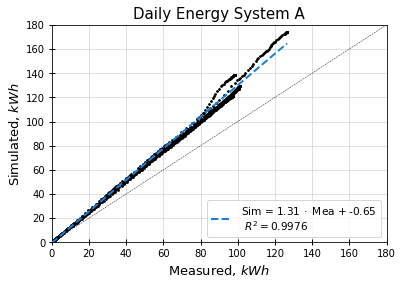

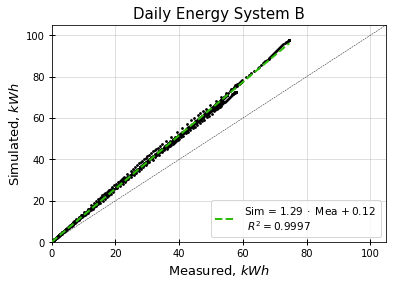

In [22]:
#System A
#Least Squares Linear Regression
x_value = measured_energy['Energy SysA, kWh']
y_value = daily_energy_SysA['Daily Energy, kWh']

coef_SysA = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA]

#Figure SysA
fig1, ax1 = plt.subplots();
axis_lim = 180

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysA*x + intercept_SysA

plt.plot(x_value, poly1d_fn_SysA(x_value), '--k',
         label=("Sim = " + f"{slope_SysA.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysA.round(2)} \n $R^2 = $" 
               + f"{r_value_SysA.round(4)}"), color='#1580E4', linewidth=2, zorder = 10)

plt.scatter(measured_energy['Energy SysA, kWh'], daily_energy_SysA['Daily Energy, kWh'], 
            color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Daily Energy System A', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $kWh$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $kWh$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_Daily_Energy_SysA.eps', bbox_inches='tight')

#System B
#Least Squares Linear Regression
x_value = measured_energy['Energy SysB, kWh']
y_value = daily_energy_SysB['Daily Energy, kWh']

coef_SysB = np.polyfit(x_value, y_value, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_value, y_value)

data_descrip = ['Slope', 'Intercept', 'r_value', 'p_value', 'Std. Error']
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB]

#Figure SysB
fig2, ax2 = plt.subplots();
axis_lim = 105

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope_SysB*x + intercept_SysB

plt.plot(x_value, poly1d_fn_SysB(x_value), '--k',
         label=("Sim = " + f"{slope_SysB.round(2)} $· \:$ Mea $+ \:$" + f"{intercept_SysB.round(2)} \n $R^2 = $" 
               + f"{r_value_SysB.round(4)}"), color='#2DBD07', linewidth=2, zorder = 10)

plt.scatter(measured_energy['Energy SysB, kWh'], daily_energy_SysB['Daily Energy, kWh'], 
            color='black', marker='o', s=3)

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Daily Energy System B', fontname="Helvetica", fontsize=15);
plt.ylabel('Simulated, $kWh$', fontname="Helvetica", fontsize=13);
plt.xlabel('Measured, $kWh$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.xlim(0, axis_lim);
plt.ylim(0, axis_lim);
plt.grid(True);
plt.legend(fontsize=10.5, loc='lower right');
plt.tight_layout;
plt.savefig('Comp_Daily_Energy_SysB.eps', bbox_inches='tight')

#### Test
```python
days = np.linspace(int(start.day), int(end.day), int(end.day)-int(start.day)+1)
hours = np.linspace(int(0), int(23), int(23)+1)

#Setting an Array of Datetime to Resample
int_hours = []
for hour in hours:
    int_hours.append(int(hour))

int_hours

str_date = []
for day in days:
    for hour in hours:
        if day < 10:
            if hour < 10:
                str_date.append('{}-0{}-0{} 0{}:00:00'.format(year, month, int(day), int(hour)))
            else:
                str_date.append('{}-0{}-0{} {}:00:00'.format(year, month, int(day), int(hour)))
        else:
            str_date.append('{}-0{}-{} {}:00:00'.format(year, month, int(day), int(hour)))
```

# END